In [1]:
# (Cell 1) 环境安装与基础导入
!pip install -q seqeval tqdm pytorch-crf gensim matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.7 MB/s eta 0:00:00


In [2]:
# Colab: 若未挂载，请挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, pickle, random, time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from seqeval.metrics import classification_report
from tqdm import tqdm

# 设定随机种子（可重复结果）
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Mounted at /content/drive
Device: cpu


In [3]:
# (Cell 2) 加载 CoNLL 文件（请修改 DATA_DIR 指向你的文件夹）
DATA_DIR = "/content/drive/MyDrive/conll2003"   # <-- 改成你的路径
SAVE_DIR = "/content/drive/MyDrive/CRFmodel"    # <-- 最终模型与映射将保存到这里
os.makedirs(SAVE_DIR, exist_ok=True)

def load_conll(path):
    sents, labs = [], []
    with open(path, encoding='utf-8') as f:
        words, tags = [], []
        for line in f:
            line=line.strip()
            if not line:
                if words:
                    sents.append(words); labs.append(tags)
                    words, tags = [], []
                continue
            if line.startswith("-DOCSTART-"):
                continue
            parts=line.split()
            if len(parts) >= 2:
                words.append(parts[0])
                tags.append(parts[-1])
    return sents, labs

train_sents, train_labels = load_conll(os.path.join(DATA_DIR, "eng.train"))
valid_sents, valid_labels = load_conll(os.path.join(DATA_DIR, "eng.testa"))
test_sents, test_labels   = load_conll(os.path.join(DATA_DIR, "eng.testb"))
print("Loaded:", len(train_sents), len(valid_sents), len(test_sents))

# Quick sample
print(train_sents[10])
print(train_labels[10])


Loaded: 14041 3250 3453
['Spanish', 'Farm', 'Minister', 'Loyola', 'de', 'Palacio', 'had', 'earlier', 'accused', 'Fischler', 'at', 'an', 'EU', 'farm', 'ministers', "'", 'meeting', 'of', 'causing', 'unjustified', 'alarm', 'through', '"', 'dangerous', 'generalisation', '.', '"']
['I-MISC', 'O', 'O', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'I-PER', 'O', 'O', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


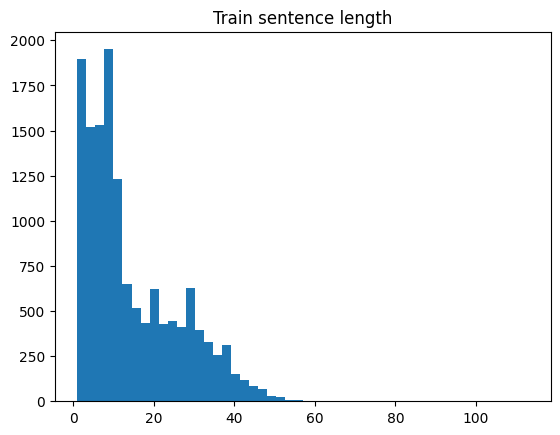

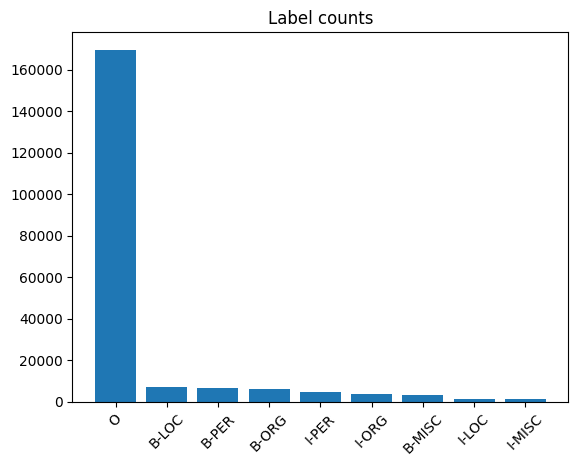

Top label counts: [('O', 169578), ('B-LOC', 7140), ('B-PER', 6600), ('B-ORG', 6321), ('I-PER', 4528), ('I-ORG', 3704), ('B-MISC', 3438), ('I-LOC', 1157), ('I-MISC', 1155)]


In [4]:
# (Cell 3) 修复 I- 标签孤立的情况并做数据探索（句长、标签分布）
def fix_bio(labels_list):
    out=[]
    for seq in labels_list:
        new=[]
        prev="O"
        for tag in seq:
            if tag.startswith("I-"):
                ent=tag[2:]
                if not prev.endswith(ent):
                    new.append("B-"+ent)
                else:
                    new.append(tag)
            else:
                new.append(tag)
            prev=new[-1]
        out.append(new)
    return out

train_labels = fix_bio(train_labels)
valid_labels = fix_bio(valid_labels)
test_labels  = fix_bio(test_labels)

# sentence length distribution
lens = [len(s) for s in train_sents]
plt.hist(lens, bins=50); plt.title("Train sentence length"); plt.show()

# label distribution
all_labels = [lbl for seq in train_labels for lbl in seq]
cnt = Counter(all_labels)
labels, vals = zip(*sorted(cnt.items(), key=lambda x:-x[1]))
plt.bar(labels, vals); plt.xticks(rotation=45); plt.title("Label counts"); plt.show()
print("Top label counts:", cnt.most_common(10))


In [5]:
# (Cell 4) 构建 vocab 和 label 映射
from itertools import chain
MIN_FREQ = 1

word_freq = Counter(word.lower() for s in train_sents for word in s)
word2id = {"<PAD>":0, "<UNK>":1}
for w, f in word_freq.items():
    if f >= MIN_FREQ:
        word2id[w] = len(word2id)

# labels (ensure 'O' exists)
unique_labels = sorted(set(chain(*train_labels)))
label2id = {lab:i for i, lab in enumerate(unique_labels)}
id2label = {i:lab for lab,i in label2id.items()}

print("Vocab size:", len(word2id), "Label size:", len(label2id))

MAX_LEN = 128
def encode_and_pad(sents, labels, max_len=MAX_LEN):
    X, Y = [], []
    for s, l in zip(sents, labels):
        ids = [word2id.get(w.lower(), 1) for w in s[:max_len]]
        labs = [label2id[t] for t in l[:max_len]]
        pad_len = max_len - len(ids)
        ids += [0]*pad_len
        labs += [label2id.get("O", 0)]*pad_len
        X.append(ids); Y.append(labs)
    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

X_train, Y_train = encode_and_pad(train_sents, train_labels)
X_val, Y_val     = encode_and_pad(valid_sents, valid_labels)
X_test, Y_test   = encode_and_pad(test_sents, test_labels)
print("Tensor shapes:", X_train.shape, Y_train.shape)


Vocab size: 21011 Label size: 9
Tensor shapes: torch.Size([14041, 128]) torch.Size([14041, 128])


In [6]:
# (Cell 5) 选择 embedding 类型： "random" 或 "glove"
EMB_DIM = 100
EMB_CHOICE = "glove"  # 改为 "random" 或 "glove"

embedding_matrix = np.random.normal(size=(len(word2id), EMB_DIM)).astype(np.float32)
if EMB_CHOICE == "glove":
    # 使用 gensim 下载 GloVe（首次需联网下载）
    import gensim.downloader as api
    glove = api.load("glove-wiki-gigaword-100")
    found = 0
    for w, idx in word2id.items():
        if w in glove:
            embedding_matrix[idx] = glove[w]
            found += 1
    print(f"GloVe loaded. Found {found}/{len(word2id)} words.")
else:
    print("Using random initialization for embeddings.")


[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe loaded. Found 18415/21011 words.


In [7]:
# (Cell 6) 模型定义与 Dataset
!pip install -q pytorch-crf
from torchcrf import CRF

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=EMB_DIM, hidden_dim=128, embedding_matrix=None, freeze_emb=False):
        super().__init__()
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=freeze_emb, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(self.embedding.embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, tagset_size)
    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        return self.fc(out)

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=EMB_DIM, hidden_dim=128, embedding_matrix=None, freeze_emb=False):
        super().__init__()
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=freeze_emb, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(self.embedding.embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)
    def forward(self, x, tags=None, mask=None):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        emissions = self.hidden2tag(out)
        if tags is not None:
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)

# Dataset wrapper
class NERDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self): return self.X.size(0)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

def make_mask(x): return (x != 0)


In [10]:
# ================================================================
#  (New Cell 7) K-Fold + Grid Search with Auto-Save & Resume
# ================================================================
GRID_SAVE_PATH = os.path.join(SAVE_DIR, "grid_progress.pkl")

# 如果已有历史搜索结果，则加载，否则初始化
if os.path.exists(GRID_SAVE_PATH):
    print(" Loading previous grid search progress...")
    with open(GRID_SAVE_PATH, "rb") as f:
        grid_state = pickle.load(f)

    results_grid = grid_state["results_grid"]
    best_cfg = grid_state["best_cfg"]
    best_f1  = grid_state["best_f1"]
    visited  = grid_state["visited"]
else:
    print(" Starting new grid search...")
    results_grid = []
    best_cfg = None
    best_f1 = 0.0
    visited = set()   # 已经跑过的组合

# 参数空间
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
params_grid = {
    'hidden_dim': [128, 256],
    'lr': [1e-3, 5e-4],
    'model_type': ['bilstm_crf', 'bilstm']
}

SEARCH_EPOCHS = 2   #  保持较小（建议 2-3），避免搜索过慢
BATCH = 32

# 遍历参数组合
for hidden_dim in params_grid['hidden_dim']:
    for lr in params_grid['lr']:
        for model_type in params_grid['model_type']:

            cfg = (model_type, hidden_dim, lr)

            #  跳过已经跑过的组合
            if cfg in visited:
                print(f" Skipping already completed configuration: {cfg}")
                continue

            print(f"\n Running grid config: {cfg}")
            visited.add(cfg)
            f1s = []

            # K-Fold
            for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
                print(f"  Fold {fold+1}/3")

                X_tr = X_train[tr_idx]; Y_tr = Y_train[tr_idx]
                X_va = X_train[va_idx]; Y_va = Y_train[va_idx]

                tr_dl = DataLoader(NERDataset(X_tr, Y_tr), batch_size=BATCH, shuffle=True)
                va_dl = DataLoader(NERDataset(X_va, Y_va), batch_size=BATCH)

                # init model
                if model_type == "bilstm_crf":
                    model = BiLSTM_CRF(
                        len(word2id), len(label2id),
                        hidden_dim=hidden_dim,
                        embedding_matrix=embedding_matrix if EMB_CHOICE == "glove" else None
                    ).to(device)
                else:
                    model = BiLSTM(
                        len(word2id), len(label2id),
                        hidden_dim=hidden_dim,
                        embedding_matrix=embedding_matrix if EMB_CHOICE == "glove" else None
                    ).to(device)

                opt = optim.Adam(model.parameters(), lr=lr)

                # short training
                for ep in range(SEARCH_EPOCHS):
                    model.train()
                    for x, y in tr_dl:
                        x, y = x.to(device), y.to(device)
                        opt.zero_grad()

                        if model_type == "bilstm_crf":
                            loss = model(x, y, mask=make_mask(x))
                        else:
                            logits = model(x)
                            loss = nn.CrossEntropyLoss(ignore_index=label2id["O"])(
                                logits.view(-1, logits.shape[-1]),
                                y.view(-1)
                            )
                        loss.backward()
                        opt.step()

                # Evaluate
                model.eval()
                trues, preds = [], []
                with torch.no_grad():
                    for x, y in va_dl:
                        x, y = x.to(device), y.to(device)
                        if model_type == "bilstm_crf":
                            mask = make_mask(x)
                            batch_preds = model(x, mask=mask)
                            for i in range(len(batch_preds)):
                                true_seq = [id2label[t.item()] for t, m in zip(y[i], mask[i]) if m]
                                pred_seq = [id2label[p] for p in batch_preds[i]]
                                trues.append(true_seq)
                                preds.append(pred_seq)
                        else:
                            logits = model(x)
                            pred = logits.argmax(-1).cpu().numpy()
                            gold = y.cpu().numpy()
                            for p, g in zip(pred, gold):
                                p_seq = [id2label[i] for i in p[:len(g)]]
                                g_seq = [id2label[i] for i in g[:len(g)]]
                                preds.append(p_seq)
                                trues.append(g_seq)

                report = classification_report(trues, preds, output_dict=True)
                f1s.append(report["micro avg"]["f1-score"])
                print(f"    Fold f1 = {f1s[-1]:.4f}")

            # 平均 F1
            mean_f1 = np.mean(f1s)
            print(f" Mean F1 = {mean_f1:.4f}")

            results_grid.append((cfg, mean_f1))

            if mean_f1 > best_f1:
                best_f1 = mean_f1
                best_cfg = cfg
                print(f" New best config: {best_cfg} (F1={best_f1:.4f})")

            #  每完成一个 config 就自动保存
            grid_state = {
                "results_grid": results_grid,
                "best_cfg": best_cfg,
                "best_f1": best_f1,
                "visited": visited
            }
            with open(GRID_SAVE_PATH, "wb") as f:
                pickle.dump(grid_state, f)
            print(" Progress saved.")

print("\n Final Best Config:", best_cfg, "F1=", best_f1)
print("Grid search completed.")


 Starting new grid search...

 Running grid config: ('bilstm_crf', 128, 0.001)
  Fold 1/3
    Fold f1 = 0.8124
  Fold 2/3
    Fold f1 = 0.8270
  Fold 3/3
    Fold f1 = 0.8095
 Mean F1 = 0.8163
 New best config: ('bilstm_crf', 128, 0.001) (F1=0.8163)
 Progress saved.

 Running grid config: ('bilstm', 128, 0.001)
  Fold 1/3
    Fold f1 = 0.0674
  Fold 2/3
    Fold f1 = 0.0744
  Fold 3/3
    Fold f1 = 0.0679
 Mean F1 = 0.0699
 Progress saved.

 Running grid config: ('bilstm_crf', 128, 0.0005)
  Fold 1/3
    Fold f1 = 0.7407
  Fold 2/3
    Fold f1 = 0.7579
  Fold 3/3
    Fold f1 = 0.7560
 Mean F1 = 0.7515
 Progress saved.

 Running grid config: ('bilstm', 128, 0.0005)
  Fold 1/3
    Fold f1 = 0.0976
  Fold 2/3
    Fold f1 = 0.0786
  Fold 3/3
    Fold f1 = 0.0080
 Mean F1 = 0.0614
 Progress saved.

 Running grid config: ('bilstm_crf', 256, 0.001)
  Fold 1/3
    Fold f1 = 0.8337
  Fold 2/3
    Fold f1 = 0.8249
  Fold 3/3
    Fold f1 = 0.8365
 Mean F1 = 0.8317
 New best config: ('bilstm_crf',

In [11]:
# (Cell 8) 根据 best_cfg 做长训练，并在验证与测试集上评估，保存模型与映射
best_model_type, best_hidden, best_lr = best_cfg
print("Final training with:", best_cfg)

# Combine train+valid for final training if desired, or train only on train
# Here use train + valid for final model to maximize data (common practice)
X_final = torch.cat([X_train, X_val], dim=0)
Y_final = torch.cat([Y_train, Y_val], dim=0)
final_ds = DataLoader(NERDataset(X_final, Y_final), batch_size=32, shuffle=True)
test_dl = DataLoader(NERDataset(X_test, Y_test), batch_size=32)

# init final model
if best_model_type == 'bilstm_crf':
    final_model = BiLSTM_CRF(len(word2id), len(label2id), hidden_dim=best_hidden,
                             embedding_matrix=embedding_matrix if EMB_CHOICE=='glove' else None).to(device)
else:
    final_model = BiLSTM(len(word2id), len(label2id), hidden_dim=best_hidden,
                         embedding_matrix=embedding_matrix if EMB_CHOICE=='glove' else None).to(device)

opt = optim.Adam(final_model.parameters(), lr=best_lr)
EPOCHS = 12

for epoch in range(EPOCHS):
    final_model.train()
    total_loss = 0
    for x,y in tqdm(final_ds, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        if best_model_type == 'bilstm_crf':
            loss = final_model(x, y, mask=make_mask(x))
        else:
            logits = final_model(x)
            loss = nn.CrossEntropyLoss(ignore_index=label2id['O'])(logits.view(-1, logits.shape[-1]), y.view(-1))
        loss.backward(); opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(final_ds):.4f}")

# Evaluate on test set
final_model.eval()
trues, preds = [], []
with torch.no_grad():
    for x,y in test_dl:
        x,y = x.to(device), y.to(device)
        if best_model_type == 'bilstm_crf':
            batch_preds = final_model(x, mask=make_mask(x))
            for i in range(len(batch_preds)):
                true_seq = [id2label[t.item()] for t, m in zip(y[i], make_mask(x)[i]) if m]
                pred_seq = [id2label[p] for p in batch_preds[i]]
                trues.append(true_seq); preds.append(pred_seq)
        else:
            logits = final_model(x)
            p = logits.argmax(-1).cpu().numpy(); g = y.cpu().numpy()
            for pp, gg in zip(p,g):
                preds.append([id2label[i] for i in pp[:len(gg)]])
                trues.append([id2label[i] for i in gg[:len(gg)]])

print("\n=== Final Test Results ===")
print(classification_report(trues, preds, digits=3))

# Save final model and mappings
MODEL_PATH = os.path.join(SAVE_DIR, "bilstm_crf_ner_model.pt")
torch.save(final_model.state_dict(), MODEL_PATH)
pickle.dump(word2id, open(os.path.join(SAVE_DIR, "word2id.pkl"), "wb"))
pickle.dump(id2label, open(os.path.join(SAVE_DIR, "id2label.pkl"), "wb"))
pickle.dump(label2id, open(os.path.join(SAVE_DIR, "label2id.pkl"), "wb"))
print("Saved model and mappings to", SAVE_DIR)


Final training with: ('bilstm_crf', 256, 0.001)


Epoch 1/12: 100%|██████████| 541/541 [06:49<00:00,  1.32it/s]


Epoch 1 Loss: 3.8500


Epoch 2/12: 100%|██████████| 541/541 [06:47<00:00,  1.33it/s]


Epoch 2 Loss: 1.3151


Epoch 3/12: 100%|██████████| 541/541 [06:35<00:00,  1.37it/s]


Epoch 3 Loss: 0.7930


Epoch 4/12: 100%|██████████| 541/541 [06:34<00:00,  1.37it/s]


Epoch 4 Loss: 0.5012


Epoch 5/12: 100%|██████████| 541/541 [06:35<00:00,  1.37it/s]


Epoch 5 Loss: 0.3094


Epoch 6/12: 100%|██████████| 541/541 [06:30<00:00,  1.38it/s]


Epoch 6 Loss: 0.1849


Epoch 7/12: 100%|██████████| 541/541 [06:18<00:00,  1.43it/s]


Epoch 7 Loss: 0.1156


Epoch 8/12: 100%|██████████| 541/541 [06:44<00:00,  1.34it/s]


Epoch 8 Loss: 0.0740


Epoch 9/12: 100%|██████████| 541/541 [06:50<00:00,  1.32it/s]


Epoch 9 Loss: 0.0612


Epoch 10/12: 100%|██████████| 541/541 [06:50<00:00,  1.32it/s]


Epoch 10 Loss: 0.0448


Epoch 11/12: 100%|██████████| 541/541 [06:50<00:00,  1.32it/s]


Epoch 11 Loss: 0.0244


Epoch 12/12: 100%|██████████| 541/541 [06:51<00:00,  1.32it/s]


Epoch 12 Loss: 0.0436

=== Final Test Results ===
              precision    recall  f1-score   support

         LOC      0.845     0.854     0.850      1668
        MISC      0.661     0.699     0.680       702
         ORG      0.803     0.706     0.751      1661
         PER      0.871     0.826     0.848      1617

   micro avg      0.816     0.783     0.799      5648
   macro avg      0.795     0.771     0.782      5648
weighted avg      0.817     0.783     0.799      5648

Saved model and mappings to /content/drive/MyDrive/CRFmodel


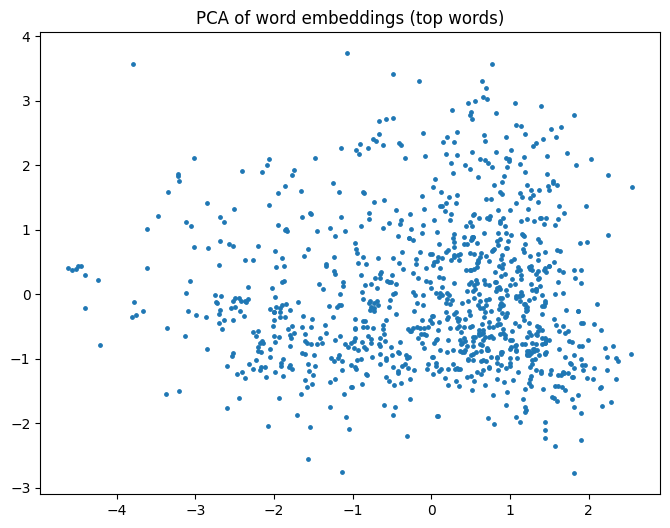

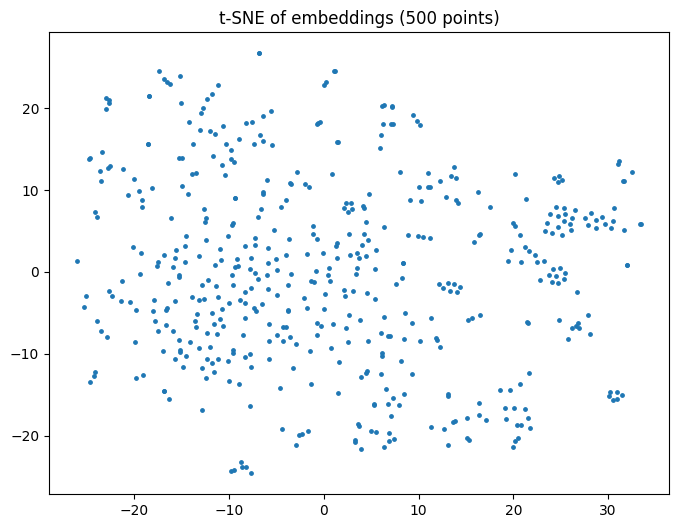

In [12]:
# (Cell 9) PCA & t-SNE 可视化（示例：可视化部分词向量或实体词向量）
# 只可视化训练词表中频率最高的 1000 个词，节省资源
top_words = [w for w,_ in word_freq.most_common(1000)]
vecs = []
labels_vis = []
for w in top_words:
    idx = word2id.get(w)
    if idx is None: continue
    vec = embedding_matrix[idx]
    vecs.append(vec)
    labels_vis.append(w)
vecs = np.vstack(vecs)

# PCA
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(vecs)
plt.figure(figsize=(8,6))
plt.scatter(pca_proj[:,0], pca_proj[:,1], s=6)
plt.title("PCA of word embeddings (top words)")
plt.show()

# t-SNE (较慢)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=SEED)
tsne_proj = tsne.fit_transform(vecs[:500])  # 500 点
plt.figure(figsize=(8,6))
plt.scatter(tsne_proj[:,0], tsne_proj[:,1], s=6)
plt.title("t-SNE of embeddings (500 points)")
plt.show()


# Methodology & Justification

- **Models compared**: BiLSTM (baseline) and BiLSTM+CRF (adds structured prediction to model label dependencies).
- **Feature exploration**: Random embeddings vs pre-trained GloVe (100d). Pre-trained vectors expected to improve semantic generalization.
- **Hyperparameter tuning**: 3-fold K-Fold quick grid search on hidden_dim and lr to select best config, then final training on combined train+val.
- **Dimensionality reduction**: PCA and t-SNE used to visualize embedding clusters to justify that similar entity words cluster.
- **Evaluation**: Report micro/macro/weighted Precision/Recall/F1 on test set (held-out).
